In [1]:
# 导入工具库
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

plt.rcParams['font.sans-serif'] = ['FangSong']  # 设置中文为仿宋
plt.rcParams['font.family'] = 'Times New Roman'  # 设置英文为 Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 确保负号显示正常

In [2]:
class Args:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_acc = []
        self.test_acc = []
        self.train_loss = []
        self.test_loss = []
        self.epochs = 40
        self.batch_size = 32
        self.num_classes = 10
        self.learning_rate = 0.01

args = Args()

In [3]:
transforms = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='../data', train=True, transform=transforms, download=True)
test_data = torchvision.datasets.CIFAR10(root='../data', train=False, transform=transforms, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)

In [5]:
imgs, labels = next(iter(train_loader))
print(imgs.shape)

torch.Size([32, 3, 32, 32])


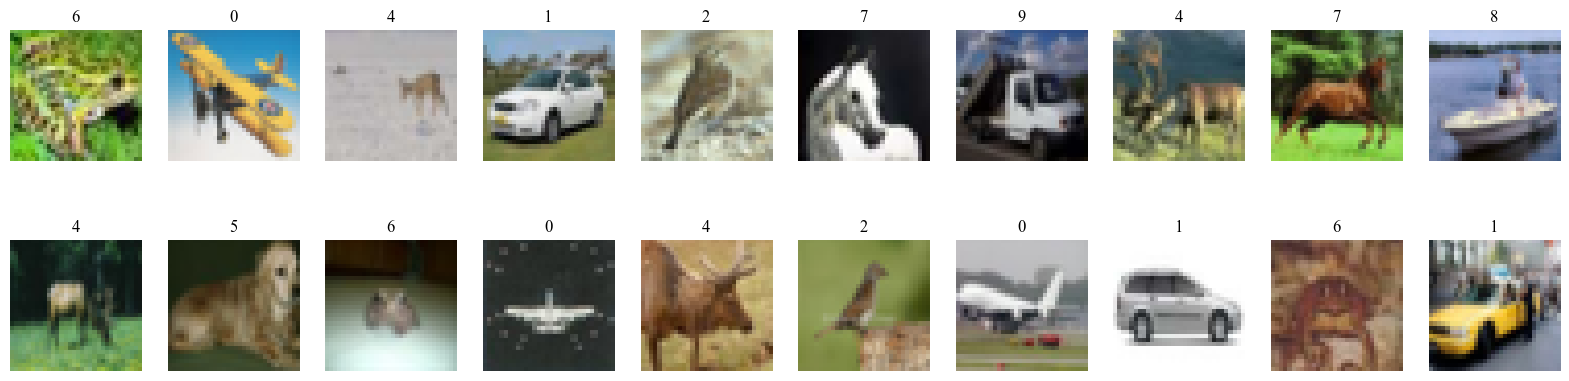

In [6]:
plt.figure(figsize=(20,5))
for i, img in enumerate(imgs[:20]):
    nping = img.numpy().transpose((1, 2, 0))
    plt.subplot(2, 10, i+1)
    plt.imshow(nping)
    plt.title(f"{labels[i]}")
    plt.axis('off')
plt.show()

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(in_features=512, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [8]:
model = CNN(args.num_classes).to(args.device)
print(summary(model, input_size=(3, 32, 32), batch_dim=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 30, 30]           1,792
├─MaxPool2d: 1-2                         [1, 64, 15, 15]           --
├─Conv2d: 1-3                            [1, 64, 13, 13]           36,928
├─MaxPool2d: 1-4                         [1, 64, 6, 6]             --
├─Conv2d: 1-5                            [1, 128, 4, 4]            73,856
├─MaxPool2d: 1-6                         [1, 128, 2, 2]            --
├─Flatten: 1-7                           [1, 512]                  --
├─Linear: 1-8                            [1, 256]                  131,328
├─Linear: 1-9                            [1, 10]                   2,570
Total params: 246,474
Trainable params: 246,474
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 9.17
Input size (MB): 0.01
Forward/backward pass size (MB): 0.57
Params size (MB): 0.99
Estimated T

In [9]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=args.learning_rate)

In [10]:
def train(dataloader, model, loss_fn, optim):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_acc, train_loss = 0, 0
    for X, y in dataloader:
        X, y = X.to(args.device), y.to(args.device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
        
    train_acc /= size
    train_loss /= num_batches
    
    return train_acc, train_loss

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_acc, test_loss = 0, 0
    for X, y in dataloader:
        X, y = X.to(args.device), y.to(args.device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        test_acc += (pred.argmax(1)==y).type(torch.float).sum().item()
        test_loss += loss.item()
    
    test_acc /= size
    test_loss /= num_batches
    
    return test_acc, test_loss

In [12]:
for epoch in range(args.epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_loader, model, loss_fn, optim)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_loader, model, loss_fn)
    
    args.train_acc.append(epoch_train_acc)
    args.test_acc.append(epoch_test_acc)
    args.train_loss.append(epoch_train_loss)
    args.test_loss.append(epoch_test_loss)
    
    template = ("Epoch: {:2d}, Train_acc: {:.1f}%, Train_loss: {:.3f}, Test_acc: {:.1f}%, Test_loss: {:.3f}")
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print("Done")

Epoch:  1, Train_acc: 15.1%, Train_loss: 2.299, Test_acc: 16.7%, Test_loss: 2.290
Epoch:  2, Train_acc: 19.1%, Train_loss: 2.230, Test_acc: 21.7%, Test_loss: 2.205
Epoch:  3, Train_acc: 22.4%, Train_loss: 2.162, Test_acc: 23.2%, Test_loss: 2.162
Epoch:  4, Train_acc: 25.5%, Train_loss: 2.106, Test_acc: 26.9%, Test_loss: 2.064
Epoch:  5, Train_acc: 30.8%, Train_loss: 2.006, Test_acc: 32.7%, Test_loss: 1.958
Epoch:  6, Train_acc: 35.2%, Train_loss: 1.912, Test_acc: 35.0%, Test_loss: 1.904
Epoch:  7, Train_acc: 37.5%, Train_loss: 1.851, Test_acc: 37.0%, Test_loss: 1.866
Epoch:  8, Train_acc: 39.5%, Train_loss: 1.801, Test_acc: 37.8%, Test_loss: 1.824
Epoch:  9, Train_acc: 41.2%, Train_loss: 1.754, Test_acc: 41.6%, Test_loss: 1.733
Epoch: 10, Train_acc: 42.5%, Train_loss: 1.712, Test_acc: 43.0%, Test_loss: 1.709
Epoch: 11, Train_acc: 44.0%, Train_loss: 1.675, Test_acc: 43.0%, Test_loss: 1.678
Epoch: 12, Train_acc: 48.0%, Train_loss: 1.579, Test_acc: 43.2%, Test_loss: 1.721
Epoch: 13, Train

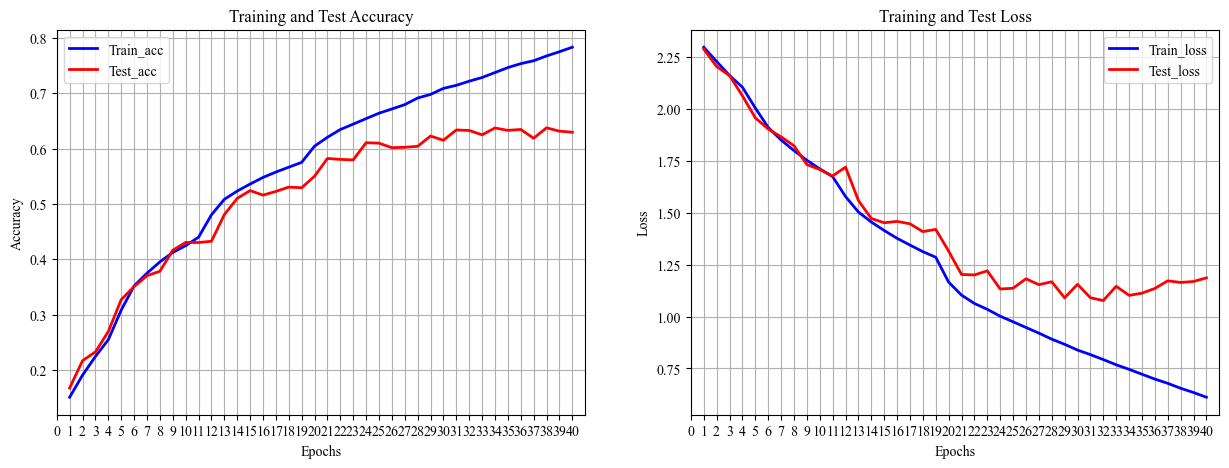

In [13]:
epoch_range = range(1,args.epochs+1)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epoch_range, args.train_acc,
         label='Train_acc',color='blue',linewidth = 2)
ax1.plot(epoch_range, args.test_acc,
         label='Test_acc',color='red',linewidth = 2)

ax1.set_title('Training and Test Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax1.legend(loc='best')

ax1.set_xlim(1,args.epochs+1)

x_ticks = np.arange(0,args.epochs+1)
ax1.set_xticks(x_ticks)
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epoch_range, args.train_loss,
         label='Train_loss',color='blue',linewidth = 2)
ax2.plot(epoch_range, args.test_loss,
         label='Test_loss',color='red',linewidth = 2)

ax2.set_title('Training and Test Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax2.legend(loc='best')

ax2.set_xlim(1,args.epochs+1)

x_ticks = np.arange(0,args.epochs+1)
ax2.set_xticks(x_ticks)
ax2.grid()

plt.savefig('../result/The_CIFAR10_Result.svg', format='svg')
plt.show()